In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [2]:
# the 4 downtempo playlist ids
APRESLIST_ID = "1Gbl0gYulJ5oXzCZWyR1Hr"
SERIOUSLY_ID = "12b7lLOydJ1rzgcp2H0uye"
ZZZ_ID = "0pWvAfI5sFdQ2DzaXXGLJ9"
SHEEP_ID = "5OJyVfvGLNO3o8rj0cHdOC"

## Fetching the data

We start by grabbing all the tracks for each playlist in batches of 100 and building up a feature matrix for each playlist using the audio features for each batch of tracks returned by the Spotify API. The relevant available features for a track are acousticness, danceability, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, and valence. It's unlikely all of these features will be helpful when building a model for each playlist but we'll go ahead and fetch all of them anyway.

In [3]:
# initialize the client with just the scope we need here (reading playlist data)
scope = 'playlist-read-private'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [4]:
features = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "valence"
]

In [46]:
# grab all the tracks from the all playlists and return their audio features

def parse_audio_features(audio_features_list: list[dict]) -> list[list[float]]:
    audio_features: list[list[float]] = []
    for af in audio_features_list:
        feature_vec = [af[feat] for feat in features]
        audio_features.append(feature_vec)
    return audio_features


def get_track_data(tracks: dict) -> list[dict]:
    data: list[dict] = []
    for t in tracks["items"]:
        tr = t["track"]
        if not tr["id"]:
            continue
        datum = {
            "id": tr["id"],
            "name": tr["name"],
            "artist": tr["artists"][0]["name"],
            "album": tr["album"]["name"],
            "uri": tr["uri"]
        }
        data.append(datum)
    return data


def get_playlist_track_data(playlist_id: str) -> tuple[list, list]:
    track_data: list[dict] = []
    track_features: list[list[float]] = []
    track_results = sp.playlist(playlist_id, fields="tracks,next")
    tracks = track_results["tracks"]
    batch_track_data = get_track_data(tracks)
    track_data.extend(batch_track_data)
    audio_feature_results = sp.audio_features([td["id"] for td in batch_track_data])
    batch_audio_features = parse_audio_features(audio_feature_results)
    track_features.extend(batch_audio_features)
    while tracks["next"]:
        tracks = sp.next(tracks)
        batch_track_data = get_track_data(tracks)
        track_data.extend(batch_track_data)
        audio_feature_results = sp.audio_features([td["id"] for td in batch_track_data])
        batch_audio_features = parse_audio_features(audio_feature_results)
        track_features.extend(batch_audio_features)
    return track_data, track_features


apreslist_track_data, apreslist_feats = get_playlist_track_data(APRESLIST_ID)
seriously_track_data, seriously_feats = get_playlist_track_data(SERIOUSLY_ID)
zzz_track_data, zzz_feats = get_playlist_track_data(ZZZ_ID)
sheep_track_data, sheep_feats = get_playlist_track_data(SHEEP_ID)


apreslist_M = np.array(apreslist_feats)
seriously_M = np.array(seriously_feats)
zzz_M = np.array(zzz_feats)
sheep_M = np.array(sheep_feats)

In [47]:
# to save calling the api again, save the ids and feats to the disk
import pickle
with open("data/apreslist_track_data.pkl", "wb") as f:
    pickle.dump(apreslist_track_data, f)
with open("data/seriously_track_data.pkl", "wb") as f:
    pickle.dump(seriously_track_data, f)
with open("data/zzz_track_data.pkl", "wb") as f:
    pickle.dump(zzz_track_data, f)
with open("data/sheep_track_data.pkl", "wb") as f:
    pickle.dump(sheep_track_data, f)

np.save("data/apreslist_M.npy", apreslist_M)
np.save("data/seriously_M.npy", seriously_M)
np.save("data/zzz_M.npy", zzz_M)
np.save("data/sheep_M.npy", sheep_M)

In [7]:
import pickle
with open("data/apreslist_track_data.pkl", "rb") as f:
    apreslist_track_data = pickle.load(f)
with open("data/seriously_track_data.pkl", "rb") as f:
    seriously_track_data = pickle.load(f)
with open("data/zzz_track_data.pkl", "rb") as f:
    zzz_track_data = pickle.load(f)
with open("data/sheep_track_data.pkl", "rb") as f:
    sheep_track_data = pickle.load(f)

apreslist_M = np.load("data/apreslist_M.npy", allow_pickle=False)
seriously_M = np.load("data/seriously_M.npy", allow_pickle=False)
zzz_M = np.load("data/zzz_M.npy", allow_pickle=False)
sheep_M = np.load("data/sheep_M.npy", allow_pickle=False)

## Approach 1: parametric models

Now we can see if certain features of tracks in a playlist follows the distribution of a parametric model. The hypothesis is that certain features for all tracks in a playlist should follow a normal-like distribution and that the parameters of the distribution should be different for each playlist.

### Energy feature

We'll start by exploring a feature which should show some variance between playlists, the "energy" feature.

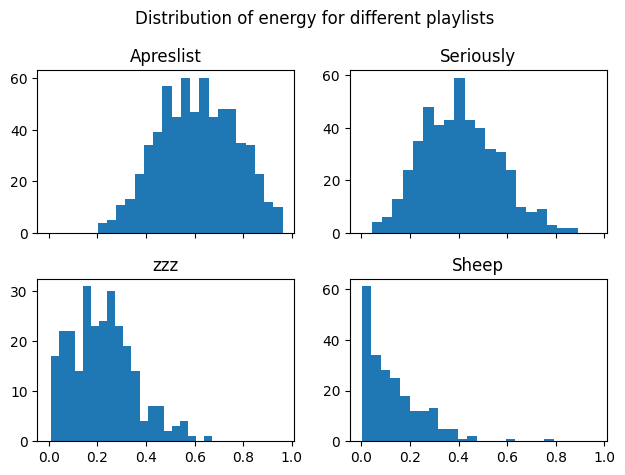

In [8]:
energy_dim = features.index("energy")

n_bins = 20
fig, axs = plt.subplots(2, 2, tight_layout=True, sharex=True)
axs[0][0].hist(apreslist_M[:,energy_dim], bins=n_bins)
axs[0][0].set_title("Apreslist")
axs[0][1].hist(seriously_M[:,energy_dim], bins=n_bins)
axs[0][1].set_title("Seriously")
axs[1][0].hist(zzz_M[:,energy_dim], bins=n_bins)
axs[1][0].set_title("zzz")
axs[1][1].hist(sheep_M[:,energy_dim], bins=n_bins)
axs[1][1].set_title("Sheep")
fig.suptitle("Distribution of energy for different playlists")
plt.show()

From first glance it seems that the distribution of energy in both Apreslist and Seriously resembles a Gaussian. It's also good to see that there is a clear distinction between where the center of the distribution lies for the two playlists, about 0.6 for Apreslist and 0.4 for Seriously. zzz seems like a bimodal with one peak around 0.1 and another around 0.3. For sheep the distribution is very different, maybe a log-normal or chi-squared. This may need some playing around with, fitting different models and selecting the one with the highest (log) likelihood. 

The simplest solution would be to consider each distribution as a univariate normal so we'll start with that. This makes it very easy to fit the parameters by maximum likelihood.

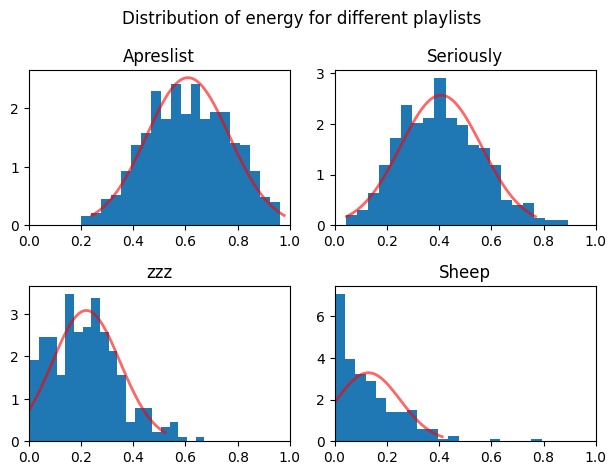

In [9]:
from scipy.stats import norm
from numpy.typing import NDArray


def fit_univariate_normal(data: NDArray):
    loc = np.mean(data)
    scale = np.std(data)
    return norm(loc, scale)


def plot_hist_and_dist(
    ax,
    data: NDArray,
    dist,
    nbins: int = 20,
    limit: tuple[float, float] | None = None,
    xlim: list[float] = [0, 1],
) -> None:
    ax.hist(data, bins=nbins, density=True)
    if limit:
        x = np.linspace(*limit, 100)
    else:
        x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
    ax.plot(x, dist.pdf(x), "r-", lw=2, alpha=0.6, label="pdf")
    ax.set_xlim(xlim)



n_bins = 20
fig, axs = plt.subplots(2, 2, tight_layout=True)
dist_1 = fit_univariate_normal(apreslist_M[:, energy_dim])
plot_hist_and_dist(axs[0][0], apreslist_M[:, energy_dim], dist_1)
axs[0][0].set_title("Apreslist")
dist_2 = fit_univariate_normal(seriously_M[:, energy_dim])
plot_hist_and_dist(axs[0][1], seriously_M[:, energy_dim], dist_2)
axs[0][1].set_title("Seriously")
dist_3 = fit_univariate_normal(zzz_M[:, energy_dim])
plot_hist_and_dist(axs[1][0], zzz_M[:, energy_dim], dist_3)
axs[1][0].set_title("zzz")
dist_4 = fit_univariate_normal(sheep_M[:, energy_dim])
plot_hist_and_dist(axs[1][1], sheep_M[:, energy_dim], dist_4)
axs[1][1].set_title("Sheep")
fig.suptitle("Distribution of energy for different playlists")
plt.show()

In [10]:
norm_ll = (
    np.sum(dist_1.logpdf(apreslist_M[:, energy_dim]))
    + np.sum(dist_2.logpdf(seriously_M[:, energy_dim]))
    + np.sum(dist_3.logpdf(zzz_M[:, energy_dim]))
    + np.sum(dist_4.logpdf(sheep_M[:, energy_dim]))
)
print(f"total log likelihood for normal distribution: {norm_ll:.2f}")

total log likelihood for normal distribution: 806.09


The fit looks decent for the first three playlists but is pretty poor for Sheep. This is likely due to the fact that the values for energy are bounded in $[0, 1]$ but that isn't taken into account when calculating the data mean and standard deviation, the parameters of the normal distribution. To make use of this constraint, we can try fitting a truncated normal (which can be constrained to a certain boundary) or beta distribution (which has a support of $(0,1)$). We'll try a beta distribution first.

The beta distribution has two paramaters, $\alpha > 0$ and $\beta > 0$. These can be fit using `scipy`'s  `scipy.stats.rv_continuous.fit` method or can fit using manual optimization methods. We'll try both and see which one gives the best results.

/Users/dominicbatten/Library/Caches/pypoetry/virtualenvs/spauditify-Q1N4rzvE-py3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/dominicbatten/Library/Caches/pypoetry/virtualenvs/spauditify-Q1N4rzvE-py3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


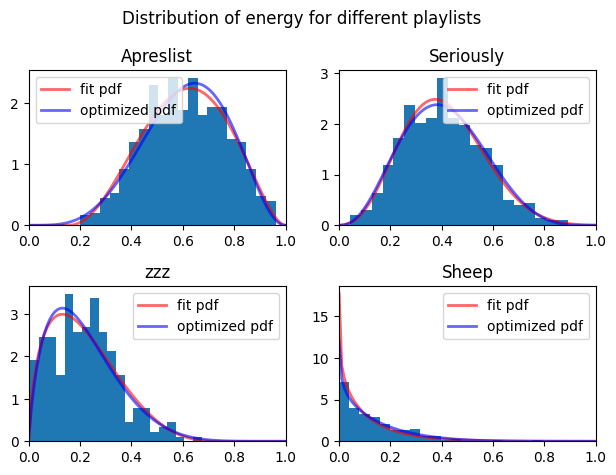

In [11]:
from scipy.stats import beta
from scipy.optimize import minimize

def fit_beta(data: NDArray):
    params = beta.fit(data)
    return beta(*params)


def fit_beta_optimized(data: NDArray):
    def func(p: tuple, r: NDArray) -> float:
        return -np.sum(beta.logpdf(r,*p))

    params = minimize(
        func,
        x0=(1,1),
        args=(data),
        bounds=((0, None), (0, None)),
    )

    return beta(*params.x)


def plot_hist_and_beta_dists(
    ax,
    data: NDArray,
    dist_fit,
    dist_optim,
    nbins: int = 20,
) -> None:
    ax.hist(data, bins=nbins, density=True)
    x = np.linspace(0.001, 0.999, 100)
    ax.plot(x, dist_fit.pdf(x), "r-", lw=2, alpha=0.6, label="fit pdf")
    ax.plot(x, dist_optim.pdf(x), "b-", lw=2, alpha=0.6, label="optimized pdf")
    ax.set_xlim([0, 1])
    ax.legend()


n_bins = 20
fig, axs = plt.subplots(2, 2, tight_layout=True)
dist_1_b = fit_beta(apreslist_M[:, energy_dim])
dist_1_o = fit_beta_optimized(apreslist_M[:, energy_dim])
plot_hist_and_beta_dists(axs[0][0], apreslist_M[:, energy_dim], dist_1_b, dist_1_o)
axs[0][0].set_title("Apreslist")
dist_2_b = fit_beta(seriously_M[:, energy_dim])
dist_2_o = fit_beta_optimized(seriously_M[:, energy_dim])
plot_hist_and_beta_dists(axs[0][1], seriously_M[:, energy_dim], dist_2_b, dist_2_o)
axs[0][1].set_title("Seriously")
dist_3_b = fit_beta(zzz_M[:, energy_dim])
dist_3_o = fit_beta_optimized(zzz_M[:, energy_dim])
plot_hist_and_beta_dists(axs[1][0], zzz_M[:, energy_dim], dist_3_b, dist_3_o)
axs[1][0].set_title("zzz")
dist_4_b = fit_beta(sheep_M[:, energy_dim])
dist_4_o = fit_beta_optimized(sheep_M[:, energy_dim])
plot_hist_and_beta_dists(axs[1][1], sheep_M[:, energy_dim], dist_4_b, dist_4_o)
axs[1][1].set_title("Sheep")
fig.suptitle("Distribution of energy for different playlists")
plt.show()

Both routines have returned good looking fitted parameters. We can verify which is best looking at the combined log likelihood across all playlists.

In [12]:
norm_ll = (
    np.sum(dist_1_b.logpdf(apreslist_M[:, energy_dim]))
    + np.sum(dist_2_b.logpdf(seriously_M[:, energy_dim]))
    + np.sum(dist_3_b.logpdf(zzz_M[:, energy_dim]))
    + np.sum(dist_4_b.logpdf(sheep_M[:, energy_dim]))
)
print(f"combined log likelihood for beta distribution with standard fitting: {norm_ll:.2f}")

norm_ll = (
    np.sum(dist_1_o.logpdf(apreslist_M[:, energy_dim]))
    + np.sum(dist_2_o.logpdf(seriously_M[:, energy_dim]))
    + np.sum(dist_3_o.logpdf(zzz_M[:, energy_dim]))
    + np.sum(dist_4_o.logpdf(sheep_M[:, energy_dim]))
)
print(f"combined log likelihood for beta distribution with optimized fitting: {norm_ll:.2f}")

combined log likelihood for beta distribution with standard fitting: 929.30
combined log likelihood for beta distribution with optimized fitting: 915.67


Standard fitting returns a better fit so we'll discard the optimized fitting routine which makes life easier anyway since standard fitting doesn't require any custom routines to be implemented. Note that both routines return a better fit compared to the combined normal distributions calculated earlier. It's possible however that the optimum combined log likelihood can be achieved by a combination of normal and beta distributions so it's best we look at the log likelihood for each individual playlists and select whichever one is a better fit. Judging from the plots, we can safely assume that the Sheep playlist is better suited to a beta distribution but we'll check anyway.

In [13]:
print("Apreslist")
print(f"Normal: {np.sum(dist_1.logpdf(apreslist_M[:, energy_dim])):.2f}")
print(f"Beta standard fit: {np.sum(dist_1_b.logpdf(apreslist_M[:, energy_dim])):.2f}")
print(f"Beta optimized fit: {np.sum(dist_1_o.logpdf(apreslist_M[:, energy_dim])):.2f}\n")

print("Seriously")
print(f"Normal: {np.sum(dist_2.logpdf(seriously_M[:, energy_dim])):.2f}")
print(f"Beta standard fit: {np.sum(dist_2_b.logpdf(seriously_M[:, energy_dim])):.2f}")
print(f"Beta optimized fit: {np.sum(dist_2_o.logpdf(seriously_M[:, energy_dim])):.2f}\n")

print("zzz")
print(f"Normal: {np.sum(dist_3.logpdf(zzz_M[:, energy_dim])):.2f}")
print(f"Beta standard fit: {np.sum(dist_3_b.logpdf(zzz_M[:, energy_dim])):.2f}")
print(f"Beta optimized fit: {np.sum(dist_3_o.logpdf(zzz_M[:, energy_dim])):.2f}\n")

print("Sheep")
print(f"Normal: {np.sum(dist_4.logpdf(sheep_M[:, energy_dim])):.2f}")
print(f"Beta standard fit: {np.sum(dist_4_b.logpdf(sheep_M[:, energy_dim])):.2f}")
print(f"Beta optimized fit: {np.sum(dist_4_o.logpdf(sheep_M[:, energy_dim])):.2f}\n")

Apreslist
Normal: 277.10
Beta standard fit: 289.86
Beta optimized fit: 285.07

Seriously
Normal: 211.28
Beta standard fit: 218.43
Beta optimized fit: 216.80

zzz
Normal: 167.49
Beta standard fit: 185.26
Beta optimized fit: 183.95

Sheep
Normal: 150.22
Beta standard fit: 235.74
Beta optimized fit: 229.86



In [14]:
# save the models to a structure to be used later
models = [[dist_1_b, dist_2_b, dist_3_b, dist_4_b]]

So it's conclusive that the beta distribution fit with the standard fitting procedure is best across the board. This feels like a good starting point to go and explore some further features. 

### Danceability

Danceability sounds like a feature that would have some clear variance across the different playlists and could therefore be a good differentiator.

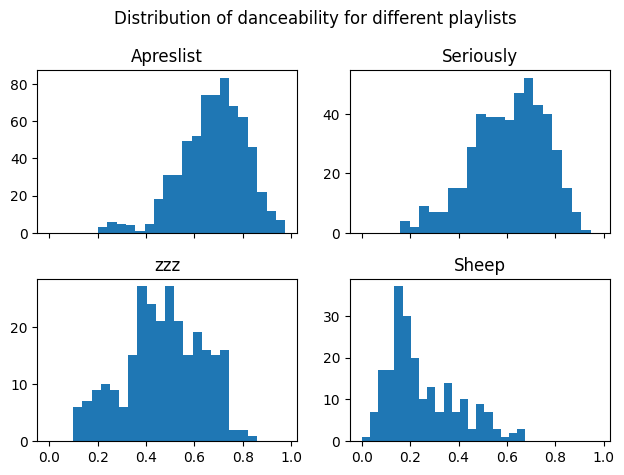

In [15]:
def plot_feature(feat_name: str, nbins: int = 20) -> None:
    feat = features.index(feat_name)

    fig, axs = plt.subplots(2, 2, tight_layout=True, sharex=True)
    axs[0][0].hist(apreslist_M[:, feat], bins=nbins)
    axs[0][0].set_title("Apreslist")
    axs[0][1].hist(seriously_M[:, feat], bins=nbins)
    axs[0][1].set_title("Seriously")
    axs[1][0].hist(zzz_M[:, feat], bins=nbins)
    axs[1][0].set_title("zzz")
    axs[1][1].hist(sheep_M[:, feat], bins=nbins)
    axs[1][1].set_title("Sheep")
    fig.suptitle(f"Distribution of {feat_name} for different playlists")
    plt.show()

plot_feature("danceability")

Looks like it's ripe for some beta distribution fitting again.

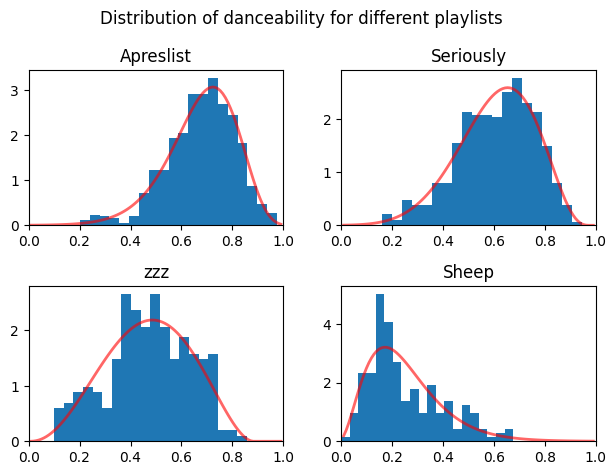

In [16]:
def fit_and_plot_beta(feat_name: str, nbins: int = 20) -> tuple:
    feat = features.index(feat_name)

    fig, axs = plt.subplots(2, 2, tight_layout=True)
    dist_1 = fit_beta(apreslist_M[:, feat])
    plot_hist_and_dist(
        axs[0][0], apreslist_M[:, feat], dist_1, limit=(0.01, 0.99), nbins=nbins
    )
    axs[0][0].set_title("Apreslist")
    dist_2 = fit_beta(seriously_M[:, feat])
    plot_hist_and_dist(
        axs[0][1], seriously_M[:, feat], dist_2, limit=(0.01, 0.99), nbins=nbins
    )
    axs[0][1].set_title("Seriously")
    dist_3 = fit_beta(zzz_M[:, feat])
    plot_hist_and_dist(axs[1][0], zzz_M[:, feat], dist_3, limit=(0.01, 0.99), nbins=nbins)
    axs[1][0].set_title("zzz")
    dist_4 = fit_beta(sheep_M[:, feat])
    plot_hist_and_dist(axs[1][1], sheep_M[:, feat], dist_4, limit=(0.01, 0.99), nbins=nbins)
    axs[1][1].set_title("Sheep")
    fig.suptitle(f"Distribution of {feat_name} for different playlists")
    plt.show()

    return dist_1, dist_2, dist_3, dist_4

db_1, db_2, db_3, db_4 = fit_and_plot_beta("danceability")

In [17]:
models.append([db_1, db_2, db_3, db_4])

### Other features

Now for the more experimental features. We'll plot acousticness, instrumentalness, loudness, and valence to see their distribution across the playlists.

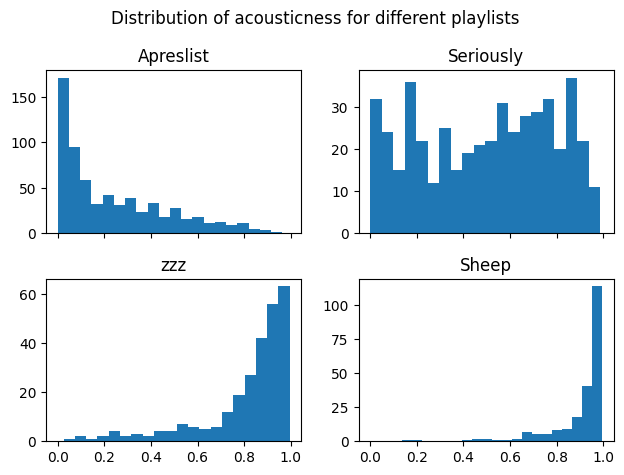

In [18]:
plot_feature("acousticness")

Interestingly the acousticness for Apreslist, zzz, and Sheep all look quite beta distributed. Seriously looks like a uniform distribution, which can actually be described as a beta distribution with $\alpha = \beta = 1$.

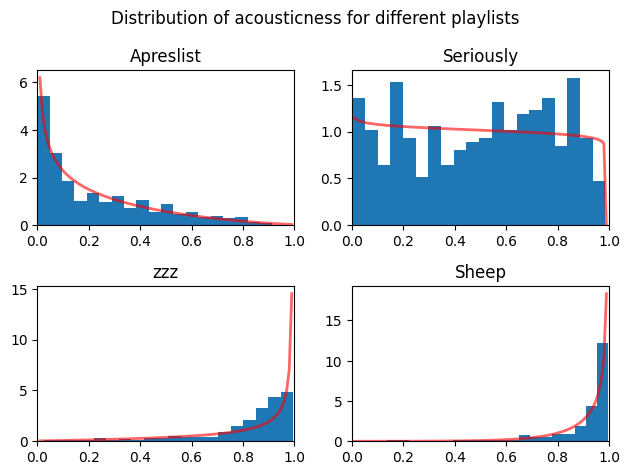

In [19]:
ab_1, ab_2, ab_3, ab_4 = fit_and_plot_beta("acousticness")

In [20]:
models.append([ab_1, ab_2, ab_3, ab_4])

In [21]:
print(f"Seriously alpha value: {ab_2.args[0]:.2f}, beta value: {ab_2.args[1]:.2f}")
print(f"zzz alpha value: {ab_3.args[0]:.2f}, beta value: {ab_3.args[1]:.2f}")
print(f"Sheep alpha value: {ab_4.args[0]:.2f}, beta value: {ab_4.args[1]:.2f}")

Seriously alpha value: 0.97, beta value: 1.03
zzz alpha value: 1.98, beta value: 0.34
Sheep alpha value: 30.09, beta value: 0.53


As expected, the alpha and beta values for Seriously are both around 1, indicating a uniform distribution. zzz and Sheep follow quite a similar distribution.

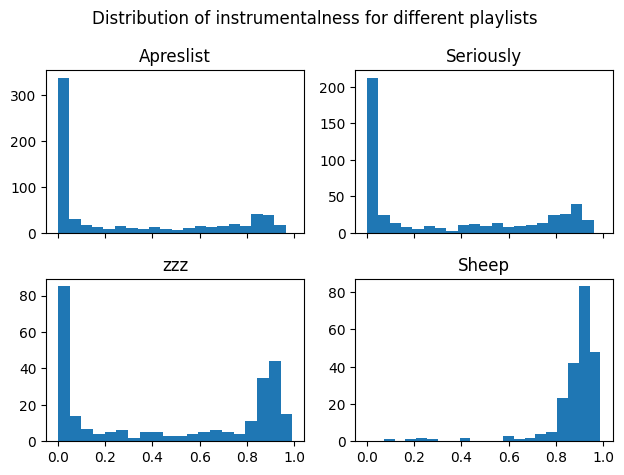

In [22]:
plot_feature("instrumentalness")

Instrumentalness looks like it wouldn't serve much benefit as a differentiator between the first three playlists. A high instrumentalness might indicate that it belongs in Sheep though.

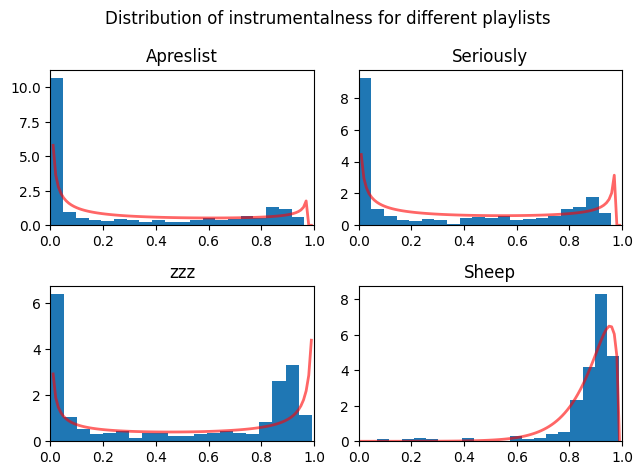

In [23]:
ib_1, ib_2, ib_3, ib_4 = fit_and_plot_beta("instrumentalness")

The beta fits for zzz and Sheep are ok, but Apreslist and Seriously aren't great. For Apreslist and Seriously, the data distribution seems to suggest that a track is very likely to be instrumentalness $= 0$ but if it's not then it's roughly uniform on $(0.1, 1)$. This is reflected somewhat in the fitted beta distributions but perhaps not to the degree that the data suggests. A better fit might be obtained by considering the distribution as some mixture of beta distributions but this increases complexity considerably and might not be worth it at this stage.

In [24]:
models.append([ib_1, ib_2, ib_3, ib_4])

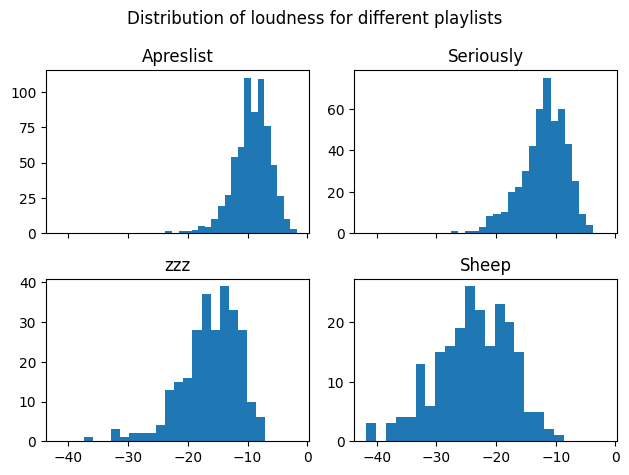

In [25]:
plot_feature("loudness")

Surprisingly, loudness looks like a really good differentiator and one that might closely follow a normal-like distribution. Note that loudness can take on any value (although typically falls in the range $(-60, 0)$ and so a beta distribution would be inappropriate. There does seem to be some skew at work here though and so a normal distribution may be unsuitable. A skewed normal might fit the bill here, it has the same parameters as a normal but with an extra one to describe the skew.

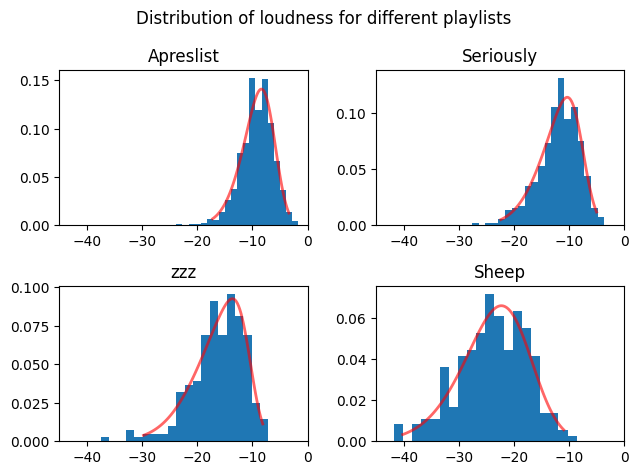

In [26]:
from scipy.stats import skewnorm

def fit_skew_normal(data: NDArray):
    params = skewnorm.fit(data)
    return skewnorm(*params)
    
loudness_dim = features.index("loudness")
n_bins = 20
fig, axs = plt.subplots(2, 2, tight_layout=True)
dist_1 = fit_skew_normal(apreslist_M[:, loudness_dim])
plot_hist_and_dist(axs[0][0], apreslist_M[:, loudness_dim], dist_1, xlim=[-45,0])
axs[0][0].set_title("Apreslist")
dist_2 = fit_skew_normal(seriously_M[:, loudness_dim])
plot_hist_and_dist(axs[0][1], seriously_M[:, loudness_dim], dist_2, xlim=[-45,0])
axs[0][1].set_title("Seriously")
dist_3 = fit_skew_normal(zzz_M[:, loudness_dim])
plot_hist_and_dist(axs[1][0], zzz_M[:, loudness_dim], dist_3, xlim=[-45,0])
axs[1][0].set_title("zzz")
dist_4 = fit_skew_normal(sheep_M[:, loudness_dim])
plot_hist_and_dist(axs[1][1], sheep_M[:, loudness_dim], dist_4, xlim=[-45,0])
axs[1][1].set_title("Sheep")
fig.suptitle("Distribution of loudness for different playlists")
plt.show()

The skewed normal fit looks quite good here.

In [27]:
models.append([dist_1, dist_2, dist_3, dist_4])

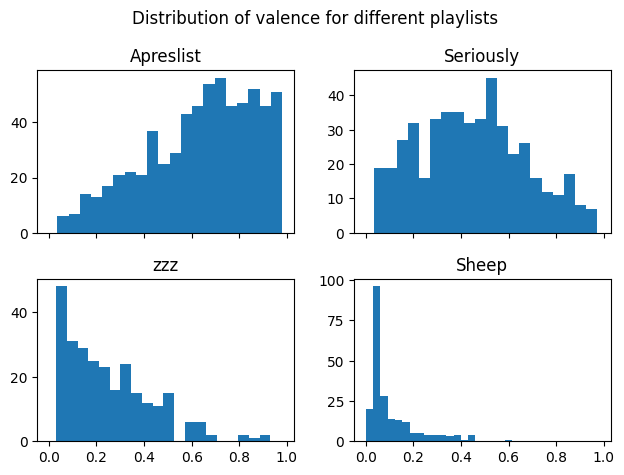

In [28]:
plot_feature("valence")

These distributions look quite interesting. Given that we're bounded by 0 and 1 again here it seems reasonable to fit a beta distribution for them.

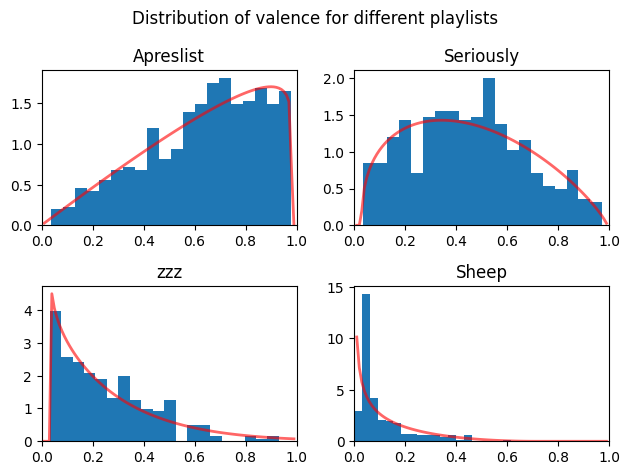

In [29]:
vb_1, vb_2, vb_3, vb_4 = fit_and_plot_beta("valence")

In [30]:
models.append([vb_1, vb_2, vb_3, vb_4])

In [31]:
with open("models/model_matrix.pkl","wb") as f:
    pickle.dump(models, f)

The fitted beta distributions all seem quite reasonable.

The remaining features are liveness, speechiness, key, tempo, and mode. I doubt any of them will reveal any insight about which playlist is best suited for a track but will try them anyway.

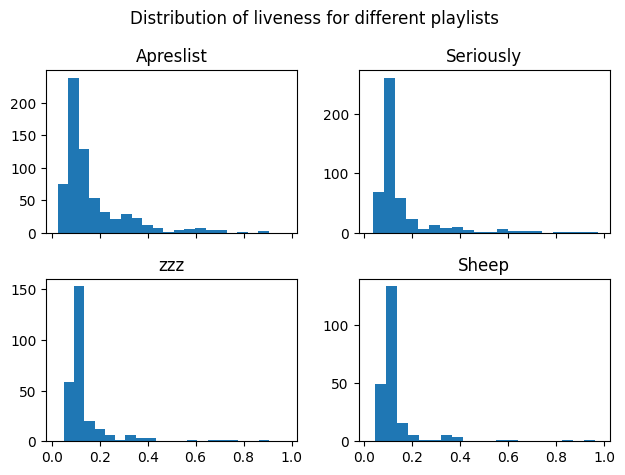

In [32]:
plot_feature("liveness")

The only thing this tells me is that I don't like live music.

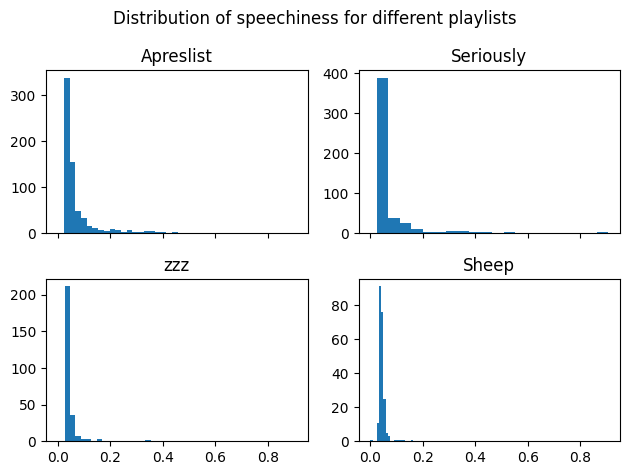

In [33]:
plot_feature("speechiness")

And the same for speechiness.

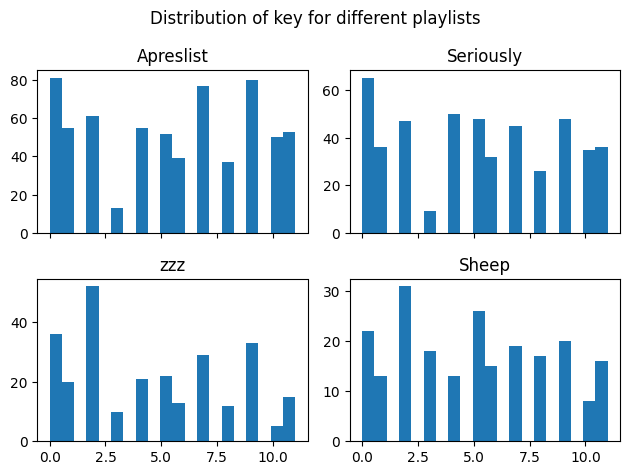

In [34]:
plot_feature("key")

As expected, this doesnt' reveal anything of any use.

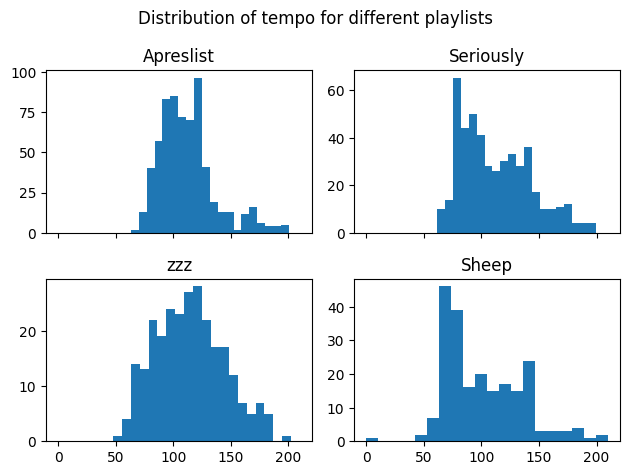

In [35]:
plot_feature("tempo")

Tempo does seem to be following some sort of normal-ish distribution here but I don't think there would be enough variance between the playlists to be of any use. We can try fitting a skewed normal to see how it looks anyway.

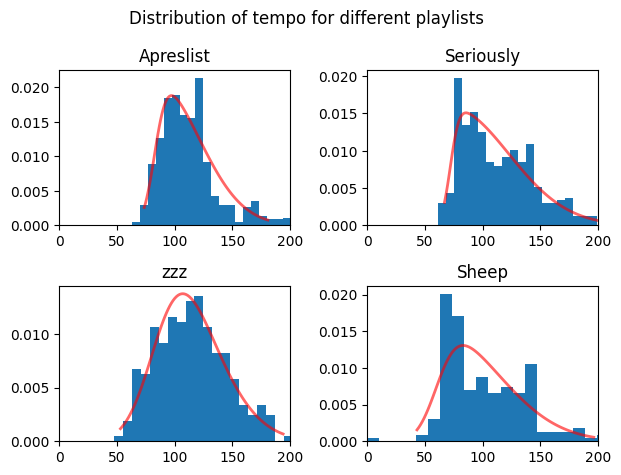

In [36]:
tempo_dim = features.index("tempo")
n_bins = 20
fig, axs = plt.subplots(2, 2, tight_layout=True)
dist_1 = fit_skew_normal(apreslist_M[:, tempo_dim])
plot_hist_and_dist(axs[0][0], apreslist_M[:, tempo_dim], dist_1, xlim=[0,200])
axs[0][0].set_title("Apreslist")
dist_2 = fit_skew_normal(seriously_M[:, tempo_dim])
plot_hist_and_dist(axs[0][1], seriously_M[:, tempo_dim], dist_2, xlim=[0,200])
axs[0][1].set_title("Seriously")
dist_3 = fit_skew_normal(zzz_M[:, tempo_dim])
plot_hist_and_dist(axs[1][0], zzz_M[:, tempo_dim], dist_3, xlim=[0,200])
axs[1][0].set_title("zzz")
dist_4 = fit_skew_normal(sheep_M[:, tempo_dim])
plot_hist_and_dist(axs[1][1], sheep_M[:, tempo_dim], dist_4, xlim=[0,200])
axs[1][1].set_title("Sheep")
fig.suptitle("Distribution of tempo for different playlists")
plt.show()

All 4 fitted skewed normal distributions seem to have a peak around 80-100 so tempo probably isn't much use when assigning a track to a playlist. Interesting to note that tempo doesn't really have that much of an effect on how "chill" a track is though.

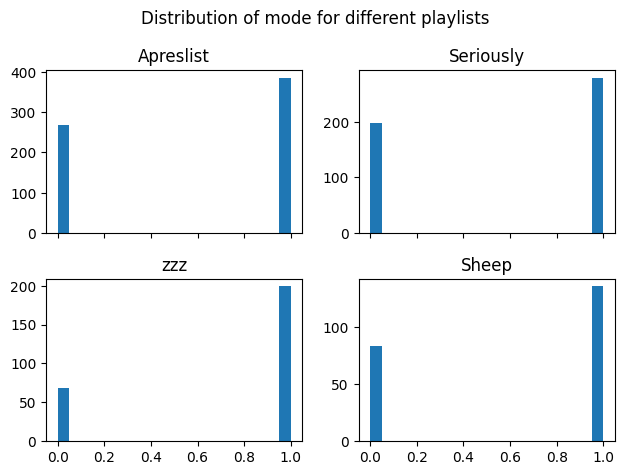

In [37]:
plot_feature("mode")

Again this won't be any use when assigning tracks to playlists but it's interesting to note that in general I prefer major (mode $= 1$) tracks to minor ones (mode $= 0$). Thought it might be the other way around.

So to recap we have 6 potentially useful features in:
* danceability
* energy
* acousticness
* instrumentalness
* loudness
* valence

All apart from loudness are well described with a beta distribution, with loudness resembling a skewed normal distribution. 

### Statistical analysis of tracks

Now we have models built for each playlist and for each feature, we can set about determining whether a track belongs in a particular playlist. For this we can sum the log likelihood for each feature for a track and for each playlist. The playlist that gives the highest log likelihood for the given track should, *statistically speaking*, be the home track.

In [38]:
with open("models/model_matrix.pkl","rb") as f:
    models = pickle.load(f)

In [75]:
# stack all the tracks together and remove all the unwanted feature columns
useful_dims = (2, 1, 0, 3, 6, 10)
all_tracks_M = np.vstack((apreslist_M, seriously_M, zzz_M, sheep_M))[:,useful_dims]

In [40]:
np.save("data/all_tracks_M", all_tracks_M)

In [ ]:
all_tracks_M = np.load("data/all_tracks_M.npy")

In [76]:
# generate the log likelihood for each dimension and cluster by playlist
apreslist_ll = np.hstack(
    [models[ii][0].logpdf(all_tracks_M[:, ii]).reshape(-1, 1) for ii in range(6)]
)
seriously_ll = np.hstack(
    [models[ii][1].logpdf(all_tracks_M[:, ii]).reshape(-1, 1) for ii in range(6)]
)
zzz_ll = np.hstack(
    [models[ii][2].logpdf(all_tracks_M[:, ii]).reshape(-1, 1) for ii in range(6)]
)
sheep_ll = np.hstack(
    [models[ii][3].logpdf(all_tracks_M[:, ii]).reshape(-1, 1) for ii in range(6)]
)

In [77]:
# sum along the rows for each playlist and horizontally concatenate the results
# this should give a nx4 matrix where n is the number of songs across all playlists
# the ith row and jth column should give the log likelihood that the ith song belongs
# in the jth playlist (0 = Apreslist, 3 = Sheep) according the models previously build
# tracks can then be assigned to playlists by determining which playlist gives the 
# highlest log likelihood
all_ll = np.hstack((
    np.sum(apreslist_ll, 1).reshape(-1, 1),
    np.sum(seriously_ll, 1).reshape(-1, 1),
    np.sum(zzz_ll, 1).reshape(-1, 1),
    np.sum(sheep_ll, 1).reshape(-1, 1),
))
all_ll[:10,:]

array([[ -1.03342719,  -3.20480886, -11.00038564, -22.27046134],
       [ -1.93857394,  -2.03843094,  -8.0937671 , -18.72750229],
       [ -0.18326124,  -1.2490961 ,  -8.17503039,         -inf],
       [  0.25734083,  -3.08936072,         -inf, -19.10647623],
       [ -0.3838438 ,  -2.91486465, -13.45073111,         -inf],
       [ -5.32051687,  -3.85767007,         -inf, -20.34408876],
       [ -1.00771684,  -1.19069677,  -7.6563278 , -19.44343739],
       [ -0.07079153,  -1.21873321,  -8.80158143, -18.67996525],
       [  0.28226145,   0.13442224,  -6.27317194, -24.33501705],
       [  5.45032671,   0.36478763,  -9.34043321,         -inf]])

In [44]:
np.argmax(all_ll, 1)[:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

From observing the first 10 results (all referencing tracks currently in Apreslist), we can see that this algorithm would assign them all to Apreslist apart from one, the 6th track. Let's find out what it is.

In [49]:
print(f"{apreslist_track_data[5]['name']} by {apreslist_track_data[5]['artist']}")

Feel Like Makin' Love by D'Angelo


You know what, that's a great shout. Let's see how the track's features look compared to the Apreslist and Seriously distributions to see exactly why the algorithm has suggested it as a candidate for moving down a playlist.

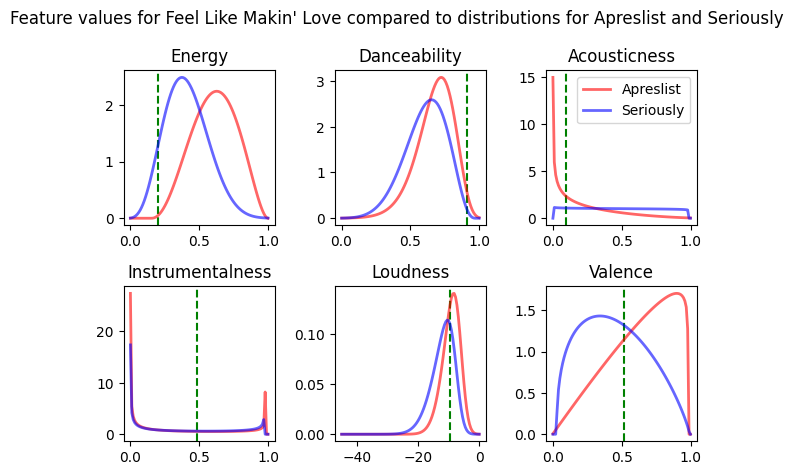

In [51]:
t = all_tracks_M[5]
bx = np.linspace(0.001, 0.999, 100)
gx = np.linspace(-45, 0, 100)
fig, axs = plt.subplots(2, 3, tight_layout=True)
axs[0][0].axvline(t[0], color="g", linestyle='--')
axs[0][0].plot(bx, models[0][0].pdf(bx), "r-", lw=2, alpha=0.6, label="Apreslist")
axs[0][0].plot(bx, models[0][1].pdf(bx), "b-", lw=2, alpha=0.6, label="Seriously")
axs[0][0].set_title("Energy")
axs[0][1].axvline(t[1], color="g", linestyle='--')
axs[0][1].plot(bx, models[1][0].pdf(bx), "r-", lw=2, alpha=0.6, label="Apreslist")
axs[0][1].plot(bx, models[1][1].pdf(bx), "b-", lw=2, alpha=0.6, label="Seriously")
axs[0][1].set_title("Danceability")
axs[0][2].axvline(t[2], color="g", linestyle='--')
axs[0][2].plot(bx, models[2][0].pdf(bx), "r-", lw=2, alpha=0.6, label="Apreslist")
axs[0][2].plot(bx, models[2][1].pdf(bx), "b-", lw=2, alpha=0.6, label="Seriously")
axs[0][2].set_title("Acousticness")
axs[0][2].legend()
axs[1][0].axvline(t[3], color="g", linestyle='--')
axs[1][0].plot(bx, models[3][0].pdf(bx), "r-", lw=2, alpha=0.6, label="Apreslist")
axs[1][0].plot(bx, models[3][1].pdf(bx), "b-", lw=2, alpha=0.6, label="Seriously")
axs[1][0].set_title("Instrumentalness")
axs[1][1].axvline(t[4], color="g", linestyle='--')
axs[1][1].plot(gx, models[4][0].pdf(gx), "r-", lw=2, alpha=0.6, label="Apreslist")
axs[1][1].plot(gx, models[4][1].pdf(gx), "b-", lw=2, alpha=0.6, label="Seriously")
axs[1][1].set_title("Loudness")
axs[1][2].axvline(t[5], color="g", linestyle='--')
axs[1][2].plot(bx, models[5][0].pdf(bx), "r-", lw=2, alpha=0.6, label="Apreslist")
axs[1][2].plot(bx, models[5][1].pdf(bx), "b-", lw=2, alpha=0.6, label="Seriously")
axs[1][2].set_title("Valence")
fig.suptitle("Feature values for Feel Like Makin' Love compared to distributions for Apreslist and Seriously")
plt.show()

The green dashed line indicates the value for this particular song for each feature. From the plots we can see that the deciding factor here is energy. The likelihood of this feature for a distribution described by the one fitted for Apreslist is very low, whereas for Seriously it's quite reasonable. The other features have resonably similar likelihoods for both playlists.

Now let's look at the entire dataset. A confusion matrix would be a nice way to see how well the algorithm agrees with my decision making when assigning tracks to playlists.

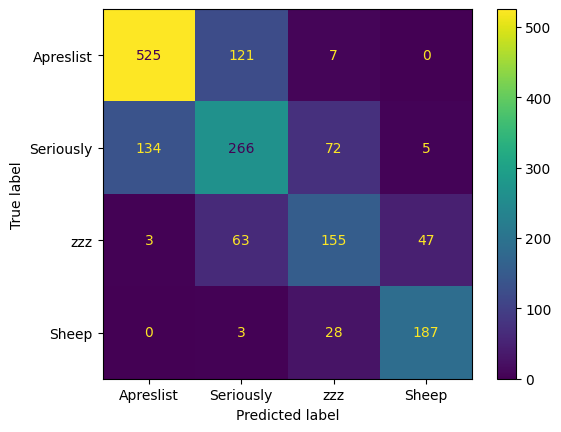

In [78]:
from sklearn import metrics

y_pred = np.argmax(all_ll, 1)
y_true = np.hstack(
    (
        np.zeros(len(apreslist_track_data)),
        np.ones(len(seriously_track_data)),
        np.ones(len(zzz_track_data)) * 2,
        np.ones(len(sheep_track_data)) * 3,
    )
)

cm = metrics.confusion_matrix(y_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Apreslist", "Seriously", "zzz", "Sheep"]
)

cm_display.plot()
plt.show()

As shown above, the algorithm has selected quite a few candidates for reshuffling for each playlist. Encouragingly it hasn't selected any candidates from Apreslist to move to Sheep and vice versa, this would intuitively be highly unlkely so it's good that the algorithm aligns with intuition. In order to decrease the number of candidates and just surface the ones that are really sticking out, it might be a good idea to set some sort of threshold increase in likelihood that would have to be met by moving a track to a different playlist. Tracks where there is only a marginal gain in likelihood by moving playlist might indicate that the track can fairly belong in either playlist, or that my initial instincts when roughly correct when first assigning the track to the given playlist.

Even in its current state, the algorithm has greatly reduced the number tracks I would need to sift through to determine whether they're in the right playlist, let's work out that exact decrease.

In [79]:
print(f"Total tracks: {len(y_pred)}")
print(f"Correctly placed tracks: {np.sum(y_pred==y_true)}")
print(f"Candidate tracks for moving: {len(y_pred)-np.sum(y_pred==y_true)}")

Total tracks: 1616
Correctly placed tracks: 1133
Candidate tracks for moving: 483


So that's about a quarter of the total number of tracks that may need auditing. Not bad.

Out of interest, let's take a look at the tracks that have been suggested as candidates to move up or down two levels, so that's 7 from Apreslist to zzz, 5 from Seriously to Sheep, 3 from zzz to Apreslist and 3 from Sheep to Seriously.

In [54]:
# apreslist -> zzz
cur_apreslist = all_ll[:len(apreslist_track_data),:]
apres_to_move_ii = np.where(np.argmax(cur_apreslist, 1) == 2)[0]
for ii in apres_to_move_ii:
    t = apreslist_track_data[ii]
    print(f"{t['name']} by {t['artist']}")

Jaded by Lone
Outro (Baked in the Sunshine) by Yellow Days
Sunshine by Mother Funk
Ce matin-là - From "L'uomo in più" by Air
Diving Platform by Nonkeen
La Faune Pélagique by Astrobal
From A Whisper To A Scream by Robert Palmer


In [60]:

def get_playlist_index(pl_name: str) -> int:
    if pl_name.lower() == "apreslist":
        return 0
    if pl_name.lower() == "seriously":
        return 1
    if pl_name.lower() == "zzz":
        return 2
    if pl_name.lower() == "sheep":
        return 3
    return 0


def plot_track_against_playlists(track_index: int, pl_1: str, pl_2: str) -> None:
    pl_1_i = get_playlist_index(pl_1)
    pl_2_i = get_playlist_index(pl_2)
    t = all_tracks_M[track_index]
    bx = np.linspace(0.001, 0.999, 100)
    gx = np.linspace(-45, 0, 100)
    fig, axs = plt.subplots(2, 3, tight_layout=True)
    axs[0][0].axvline(t[0], color="g", linestyle="--")
    axs[0][0].plot(bx, models[0][pl_1_i].pdf(bx), "r-", lw=2, alpha=0.6, label=pl_1)
    axs[0][0].plot(bx, models[0][pl_2_i].pdf(bx), "b-", lw=2, alpha=0.6, label=pl_2)
    axs[0][0].set_title("Energy")
    axs[0][1].axvline(t[1], color="g", linestyle="--")
    axs[0][1].plot(bx, models[1][pl_1_i].pdf(bx), "r-", lw=2, alpha=0.6, label=pl_1)
    axs[0][1].plot(bx, models[1][pl_2_i].pdf(bx), "b-", lw=2, alpha=0.6, label=pl_2)
    axs[0][1].set_title("Danceability")
    axs[0][2].axvline(t[2], color="g", linestyle="--")
    axs[0][2].plot(bx, models[2][pl_1_i].pdf(bx), "r-", lw=2, alpha=0.6, label=pl_1)
    axs[0][2].plot(bx, models[2][pl_2_i].pdf(bx), "b-", lw=2, alpha=0.6, label=pl_2)
    axs[0][2].set_title("Acousticness")
    axs[0][2].legend()
    axs[1][0].axvline(t[3], color="g", linestyle="--")
    axs[1][0].plot(bx, models[3][pl_1_i].pdf(bx), "r-", lw=2, alpha=0.6, label=pl_1)
    axs[1][0].plot(bx, models[3][pl_2_i].pdf(bx), "b-", lw=2, alpha=0.6, label=pl_2)
    axs[1][0].set_title("Instrumentalness")
    axs[1][1].axvline(t[4], color="g", linestyle="--")
    axs[1][1].plot(gx, models[4][pl_1_i].pdf(gx), "r-", lw=2, alpha=0.6, label=pl_1)
    axs[1][1].plot(gx, models[4][pl_2_i].pdf(gx), "b-", lw=2, alpha=0.6, label=pl_2)
    axs[1][1].set_title("Loudness")
    axs[1][2].axvline(t[5], color="g", linestyle="--")
    axs[1][2].plot(bx, models[5][pl_1_i].pdf(bx), "r-", lw=2, alpha=0.6, label=pl_1)
    axs[1][2].plot(bx, models[5][pl_2_i].pdf(bx), "b-", lw=2, alpha=0.6, label=pl_2)
    axs[1][2].set_title("Valence")
    fig.suptitle("Feature values compared to distributions for Apreslist and Seriously")
    plt.show()


Let's plot Sunshine first

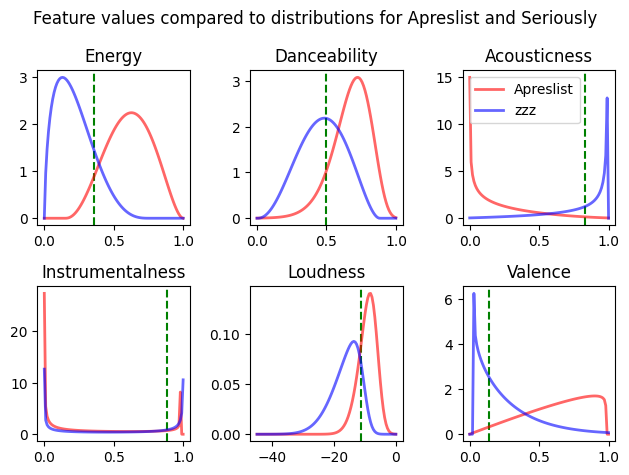

In [61]:
track_1 = np.where(np.argmax(cur_apreslist, 1) == 2)[0][2]
plot_track_against_playlists(track_1, "Apreslist", "zzz")

Valence and danceability of Sunshine is really pushing this track down the playlists. 

Now let's look at Diving Platform which, imho, is quite an energetic track.

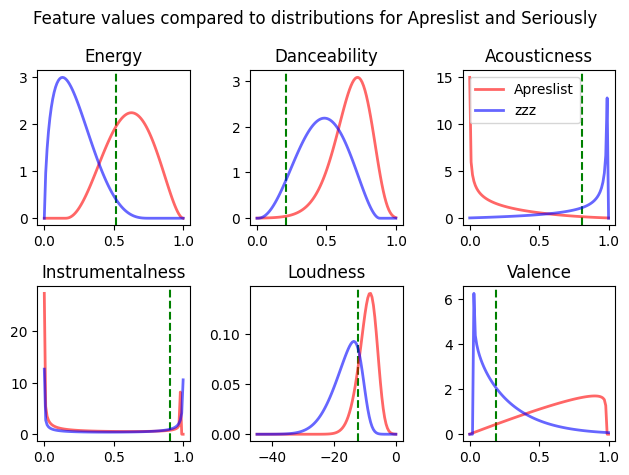

In [62]:
track_2 = np.where(np.argmax(cur_apreslist, 1) == 2)[0][4]
plot_track_against_playlists(track_2, "Apreslist", "zzz")

As expected, the energy of the track quite closely matches that of Apreslist, but the danceability and valence are much better suited to zzz. I think this track suffers from being a track of two halves, the first half is quite downtempo and is probably better suited to zzz. The second half ramps up a lot and gets quite euphoric, almost chaotic. If I think of zzz as a playlist for sleeping then I can imagine myself being jolted awake by the second half of this track. This raises some potential tweaks to the algorithm to give increased or decreased importance to a feature by assigning it a weight.

## Approach 2: classification models